In [ ]:
from google.colab import files
uploaded = files.upload()


Saving datos_tratados.csv to datos_tratados.csv


In [ ]:

import pandas as pd

url = 'https://github.com/mariantocostanzo/Challange_Telecom_X_parte2'
url
df = pd.read_csv(url)



,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [ ]:
#nombres de las columnas
print(df.columns.tolist())


['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']


In [ ]:
# Se elimina la columna 'customerID' y las filas que contengan valores nulos
df = df.drop(columns=["customerID"])
df = df.dropna()

# Verificamos que no queden valores nulos
print("¿Hay valores nulos?:", df.isnull().values.any())

# Mostramos las dimensiones del dataset limpio
print("Tamaño del DataFrame después de limpieza:", df.shape)


¿Hay valores nulos?: False
Tamaño del DataFrame después de limpieza: (7043, 20)


## 📦 Se codifican las variables categóricas

| Tipo de variable                           | Método aplicado|
| ------------------------------------------ | ------------------------------------- |
| Categóricas binarias (2 valores)           | Label Encoding (`Yes`→1, `No`→0)      |
| Categóricas no binarias (más de 2 valores) | One-Hot Encoding (columnas separadas) |


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1.'account.Charges.Total' a numérico
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# 2. Se identifican las columnas categóricas
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# 3. Se detectan las binarias (solo 2 valores únicos, ignorando NaNs)
binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]

# 4. Se aplica Label Encoding a columnas binarias
label_encoder = LabelEncoder()
for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

# 5. Se aplica One-Hot Encoding al resto de las columnas categóricas
multi_cat_cols = [col for col in categorical_cols if col not in binary_cols]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# Se muestran las primeras filas del DataFrame transformado
df.head()


,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total,...,internet.TechSupport_Yes,internet.StreamingTV_No internet service,internet.StreamingTV_Yes,internet.StreamingMovies_No internet service,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,0,0,1,1,9,1,1,65.6,593.30,...,True,False,True,False,False,True,False,False,False,True
1,0,1,0,0,0,9,1,0,59.9,542.40,...,False,False,False,False,True,False,False,False,False,True
2,1,1,0,0,0,4,1,1,73.9,280.85,...,False,False,False,False,False,False,False,False,True,False
3,1,1,1,1,0,13,1,1,98.0,1237.85,...,False,False,True,False,True,False,False,False,True,False
4,1,0,1,1,0,3,1,1,83.9,267.40,...,True,False,True,False,False,False,False,False,False,True


## ✅ Proporción entre los que cancelaron y no

In [ ]:
# Cantidad de clientes que cancelaron y los que no
cancel_counts = df['Churn'].value_counts()

# Total y porcentaje de cada clase
print("Cantidad por clase:")
print(cancel_counts)

print("\nProporción por clase:")
print(cancel_counts / cancel_counts.sum())


Cantidad por clase:
Churn
0    5174
1    1869
Name: count, dtype: int64

Proporción por clase:
Churn
0    0.73463
1    0.26537
Name: count, dtype: float64


##✅ Código para escalar las variables numéricas
##Se uso StandardScaler, que estandariza con media 0 y desviación 1


In [ ]:
from sklearn.preprocessing import StandardScaler

# Identificamos columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('Churn')  # No queremos escalar la variable objetivo

# Creamos un escalador
scaler = StandardScaler()

# Aplicamos el escalado a las columnas numéricas
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Mostramos un ejemplo
df_scaled[numeric_cols].head()


,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total
0,-1.009559,-0.439916,1.034530,1.529024,-0.951682,0.327438,0.829798,0.027862,-0.745607
1,0.990532,-0.439916,-0.966622,-0.654012,-0.951682,0.327438,-1.205113,-0.161583,-0.768063
2,0.990532,-0.439916,-0.966622,-0.654012,-1.155283,0.327438,0.829798,0.303720,-0.883456
3,0.990532,2.273159,1.034530,-0.654012,-0.788800,0.327438,0.829798,1.104706,-0.461240
4,-1.009559,2.273159,1.034530,-0.654012,-1.196004,0.327438,0.829798,0.636080,-0.889390


##✅ Cálculo y vizualición de la matriz de correlación


/tmp/ipython-input-4038040072.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.values, y=churn_corr.index, palette=colors, legend=False)


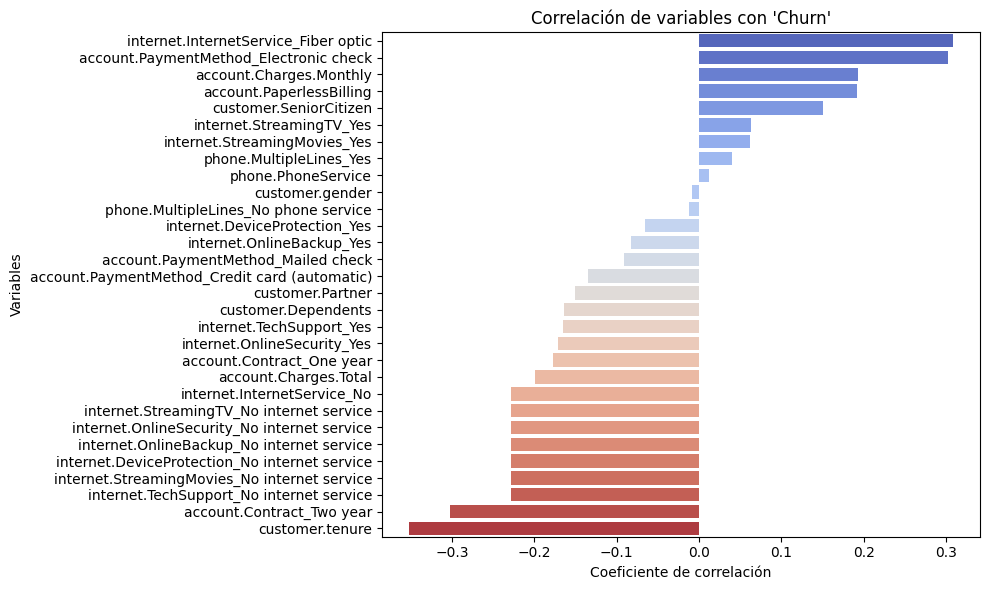

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# se ordenan las correlaciones con Churn
churn_corr = df.corr(numeric_only=True)["Churn"].drop("Churn").sort_values(ascending=False)

# lista de colores basada en los valores de correlación
colors = sns.color_palette("coolwarm", len(churn_corr))
colors = [colors[i] for i in range(len(colors))]

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette=colors, legend=False)
plt.title("Correlación de variables con 'Churn'")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()




##🔟 Top 10 variables más correlacionadas con Churn:

##Las variables con correlación positiva alta (más propensas a que el cliente cancele):

| Variable                              | Correlación alta positiva  |
|---------------------------------------|----------------------------|
| internet.InternetService_Fiber optic  | +0.3 aprox.                |
| account.PaymentMethod_Electronic check| +0.3 aprox.                |
| account.Charges.Monthly               | +0.25 aprox.               |
| account.PaperlessBilling              | +0.2 aprox.                |
| customer.SeniorCitizen                | +0.15 aprox.               |

###Estas variables aumentan la probabilidad de que un cliente cancele.

##Las variables con correlación negativa (más asociadas a permanencia):

| Variable                               | Correlación negativa     |
|----------------------------------------|--------------------------|
| customer.tenure                        | –0.35 aprox.             |
| account.Contract_Two year              | –0.3 aprox.              |
| internet.TechSupport_No                | –0.25 aprox.             |
| account.Contract_One year              | –0.2 aprox.              |
| internet.OnlineSecurity_Yes            | –0.2 aprox.              |   

###Estas reducen la probabilidad de cancelación (fidelidad del cliente).



/tmp/ipython-input-1950508606.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette=colors)


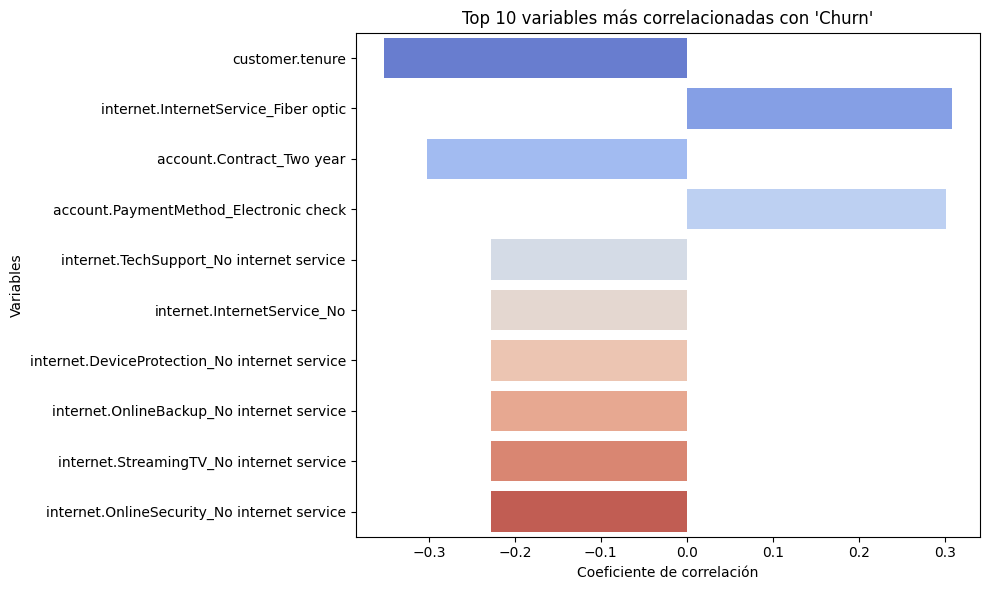

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar las correlaciones por valor absoluto
churn_corr_abs = churn_corr.abs().sort_values(ascending=False)

# Seleccionar las top 10 variables
top_10_corr = churn_corr.loc[churn_corr_abs.head(10).index]

# lista de colores basada en los valores de correlación
colors = sns.color_palette("coolwarm", len(top_10_corr))


plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index, palette=colors)
plt.title("Top 10 variables más correlacionadas con 'Churn'")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()